In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.signal as ssig

from scipy.optimize import curve_fit

#Standard styling for plots
plt.rc("axes", labelsize=18)   # skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=16, top=True, direction="in")  # skriftstørrelse af ticks og viser ticks øverst
plt.rc("ytick", labelsize=16, right=True, direction="in")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=12)


plt.rc('font', size=16)

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/FysikCamp2024/eksperimential_fysik/X-ray_Diffraction/"

## Dataformatering og indhentning

Her skal I på linje 47-49 ændre navnene på paths til de respektive navne jeres kalibreringsfiler har

In [2]:
'''Here is some spaghetti, the computer in lab have encoded the information
really wierd. The below function can exctract data from a path'''

def path_to_xy_lt(data_path):
  #Takes a path and returns the data in to lists collected in a tuple
  #The tuple just makes is easier to unpack the data

  # This is nessecary since the computer in lab have some wierd encoding. Found
  # the solution on stackoverflow
  doc = open(data_path, 'r', encoding='windows-1252')

  channels, counts = [],[]
  livetime = 0 # Has to be here for the Americium dataset, since it has another format
  for i,datapoint in enumerate(doc):
    
    if data_path == Am_data_path:
      # The try-except statement ensures that only data is encoded. Whenever
      # there is any text, it is skipped. No need for skiprows or max_row
      try:
        x,y = datapoint.split('\t')
        channels.append(float(x))
        counts.append((float(y)))
      except Exception:
          pass
        
    else:
      try:
        counts.append(float(datapoint))
        channels.append(i)
      except ValueError:
        if datapoint.split()[0] == 'LIVE_TIME':
            _,_,lt = datapoint.split()
            livetime = float(lt)

  return channels, counts, livetime

# Following function adds and error of 1 to the 'zero' counts
def correct_errors(counts_err):
  corrected_errors = []
  for count_err in counts_err:
    if count_err == 0.0:
      corrected_errors.append(1)
    else:
      corrected_errors.append(count_err)
  return corrected_errors

Am_data_path = path + r'Kalibrering/am test kalibrering.txt'
Fe_data_path = path + r'Kalibrering/Fe55kalibrering.txt'
Cs_data_path = path + r'Kalibrering/cs137 kalibrering.txt'

# Extract data
Am_channels, Am_counts,_ = path_to_xy_lt(Am_data_path)
# Find error on the counts
Am_counts_err = [np.sqrt(count) for count in Am_counts]
# Giving an uncertainty to all the errors which is zero
Am_counts_err = correct_errors(Am_counts_err)
# Packs the data nicely in the order: channels, counts, error on counts.
# This makes the tiresome gauss-fitting easier
Am_data = (Am_channels, Am_counts, Am_counts_err)

Fe_channels, Fe_counts,_ = path_to_xy_lt(Fe_data_path)
Fe_counts_err = [np.sqrt(count) for count in Fe_counts]
Fe_counts_err = correct_errors(Fe_counts_err)
Fe_data = (Fe_channels, Fe_counts, Fe_counts_err)

Cs_channels, Cs_counts,_ = path_to_xy_lt(Cs_data_path)
Cs_counts_err = [np.sqrt(count) for count in Cs_counts]
Cs_counts_err = correct_errors(Cs_counts_err)
Cs_data = (Cs_channels, Cs_counts, Cs_counts_err)

## Fejlpropagering

In [15]:
#Defining the function as per: https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Example_formulae
#Doing initial error propagation with mode labeling the expressions with 1 = top and so on
#Assumes no covariance
def error_prop(a,b,A,B,Asig,Bsig,mode):
    if mode == 1:
        return np.sqrt(a*a*Asig*Asig) #f = a*A
    
    elif mode == 2:
        return np.sqrt(a*a*Asig*Asig+b*b*Bsig*Bsig) #f = a*A + b*B
    
    elif mode == 3:
        return np.sqrt(a*a*Asig*Asig+b*b*Bsig*Bsig) #f = a*A - b*B
    
    elif mode == 4:
        return np.sqrt(Asig**2 + Bsig**2) #f = A - B
    
    elif mode == 5:
        return np.absolute(A*B) * np.sqrt(((Asig/A)**2 + (Bsig/B)**2)) #f = A*B
    
    elif mode == 6:
        return np.absolute(A/B) * np.sqrt(((Asig/A)**2 + (Bsig/B)**2)) #f = A/B
    
    elif mode == 7:
        return np.absolute(a*b*A**(b-1)*Asig) #a*A**b

## Kalibrering

####################################################
Fitting around the peak at channel 546
---
A = 3.96e-16 +- 2.3
mu = 546.0 +- 5.541e+07
sigma = 1.0 +- 5.5e+07
---
covariance matrix =
 [[ 5.29591900e+00 -5.46301593e-04  7.26734614e+07]
 [-5.46301593e-04  3.07030239e+15 -1.24900361e+10]
 [ 7.26734614e+07 -1.24900361e+10  3.01558656e+15]]
####################################################


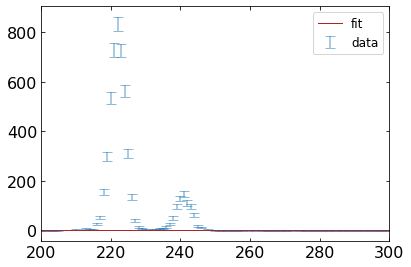

In [4]:
# defining a function to make some fits
def fitting_func(x, A,mu,sigma):
  x = np.array(x)
  return A/(sigma * np.sqrt(2*np.pi)) * np.exp(-1/2 * (x-mu)**2/(sigma**2))

# Following function makes it possible to make a fit in the desired range around
# the desired channel
def fit_from_guess(fitting_function, data, initial_guesses = [], range=50):
  '''The data argument is a tuple of data in the order: (channel, count, error on
  count). The function returns the tuple (p_opt, p_cov)

  A disadvantage of this function, is that the intial guess, apart from the
  average, is constant for all the fits. They can be modified right here in
  the function'''
  xs, counts, counts_err = data
  _, xguess, _= initial_guesses
  # finding the index where the channel guess is:
  for i, x in enumerate(xs):
    if x-xguess <= 0.5:
      index_guess = i

  xs_ = xs[index_guess - range: index_guess + range]
  counts_ = counts[index_guess - range: index_guess + range]
  counts_err_ = counts_err[index_guess - range: index_guess + range]
  # try:
  p_opt, p_cov = curve_fit(fitting_function, xs_, counts_,
                          initial_guesses, counts_err_,
                          absolute_sigma = True)
  # except:
  #   print('An exception is called')
      
  return p_opt, p_cov

def make_fit(data, initial_guesses, range=50):
    A_guess, mu_guess, sigma_guess = initial_guesses
    channels, counts, counts_err = data

    assert len(channels) == 2048
    print('#'*52 + '\n' + f'Fitting around the peak at channel {mu_guess}')

    p_opt, p_cov = fit_from_guess(fitting_func, data, initial_guesses, 50)

    A, mu, sigma = p_opt

    print(f'---\n{A = :.3} +- {np.sqrt(p_cov[0][0]) :.2}')
    print(    f'{mu = :.5} +- {np.sqrt(p_cov[1][1]) :.5}')
    print( f'{sigma = :.3} +- {np.sqrt(p_cov[2][2]) :.2}')
    print(f'---\ncovariance matrix =\n {p_cov}')
    print('#'*52)


    fig, ax=plt.subplots()
    ax.errorbar(channels, counts, counts_err, fmt='o', markersize=0.01, capsize=5,
              alpha=0.5, label='data')
    ax.plot(channels, fitting_func(channels, A,mu,sigma),
          linewidth=1, c='firebrick', label='fit')
    ax.legend()
    
    ax.set_xlim(200, 300)

    fig.tight_layout()


# Change line under here to whatever data you're using to calibrate
make_fit(Fe_data, (10, 546, 1))

In [8]:
'''Following code unpack the calibration data file
We make the file ourselves, and avoid writing raw data in the jupyter notebook'''
channel_peaks = []
channel_errs = []
energies = []
cali_doc = open('Kalibrering/Calibration_data.txt')
for line in cali_doc:
    line_list = line.split()
    # If the line is just an empty line we continue to the next line
    if len(line_list) == 0:
        continue

    # If we cannot convert the text to a float, then the exception 'ValueError' is called. Thus
    # only when we are a place in the document where we have valid data we unpack the data
    try:
        for i,element in enumerate(line_list):
            # In the document the lines contain the data in the order: peak, peak_error, energy
            if i == 0:
                channel_peaks.append(float(element))
            elif i == 1:
                channel_errs.append(float(element))
            elif i == 2:
                energies.append(float(element))
            else:
                pass

    except ValueError:
        pass
assert len(channel_peaks) == len(energies)


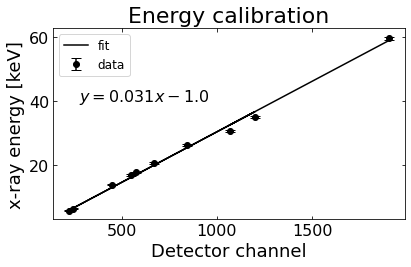

In [10]:

# Fitting the data with a linear function
def lin_fit(x, m,b): return m*np.array(x)+b
p_opt_cal, p_cov_cal = curve_fit(lin_fit, channel_peaks, energies, [1,0.01], sigma=channel_errs, absolute_sigma=True)
m,b = p_opt_cal
m_err, b_err = p_cov_cal[0][0], p_cov_cal[1][1]

# plotting it all
fig,ax=plt.subplots()
fs = 15

ax.errorbar(channel_peaks, energies, yerr=channel_errs, fmt='o', capsize=5, c='black', label='data')
ax.plot(channel_peaks, lin_fit(channel_peaks, m, b), c='black', label='fit')

ax.text(250, 40, f' $y= {m :.2} x - {abs(b):.2} $')
ax.set_title('Energy calibration')
ax.set_xlabel('Detector channel')
ax.set_ylabel('x-ray energy [keV]')

ax.legend()


fig.tight_layout()

## Laue Diffraction to determine spacing between diffraction planes

Here we can fit to each peak of the spectrum yielding us an energy through the calibration, from this energy we can calculate the wavelength of the given x-rays via the de Broglie formula

$$ \lambda = \frac{hc}{E}$$

Then we can input this into the Bragg formula to find an expression for the energy as a function of integer n

$$ n\lambda = 2dsin(\theta)$$

$$n\frac{hc}{E} = 2dsin(\theta)$$

$$ E(n) = \frac{hc}{2dsin(\theta)}n + E_{constant}$$

This is linear in n and we can thus fit a linear function to this, here we can then calculate d from knowing the angle and all the other constants in the term for the slope.

## Importerer krystal data

Her skal I ændre de to forskellige paths til navnene på jeres filer i stedet

In [11]:
#Getting the data, here 45 includes both x-ray diffraction and fluorescence peaks, not_45 has only fluorescence peaks
#such that these can be filtered out



glimmer_45_path = path + "Data/glimmer 45 grader.txt"
glimmer_not_45_path = path + "Data/glimmer ikke 45 grader.txt"

#Defining channels, counts and measurement time for each file
glimmer_45_channels, glimmer_45_counts, glimmer_45_measurement_time = path_to_xy_lt(glimmer_45_path)
glimmer_not_45_channels, glimmer_not_45_counts, glimmer_not_45_measurement_time = path_to_xy_lt(glimmer_not_45_path)

#Finding the errors just as sqrt(counts) as its poisson data
glimmer_45_counts_error = np.sqrt(glimmer_45_counts)
glimmer_45_counts_error = correct_errors(glimmer_45_counts_error)

glimmer_not_45_counts_error = np.sqrt(glimmer_not_45_counts)
glimmer_not_45_counts_error = correct_errors(glimmer_not_45_counts_error)

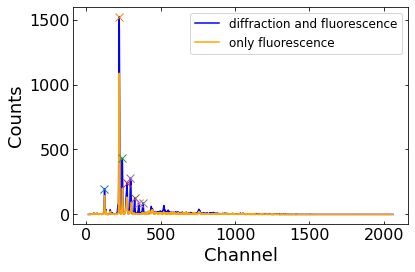

In [12]:
#Determining, which peaks are purely x-ray diffraction
fig, ax = plt.subplots(1,1)

ax.plot(glimmer_45_channels,glimmer_45_counts,color = "blue",label="diffraction and fluorescence")
ax.plot(glimmer_not_45_channels,glimmer_not_45_counts, color="orange",label = "only fluorescence")

#Finding peaks
glimmer_45_peaks = ssig.find_peaks(glimmer_45_counts, height = 80,distance = 10)[0] #this yields the index where it finds peaks

#plotting peaks for the blue spectrum
for i in glimmer_45_peaks:
    ax.plot(glimmer_45_channels[i],glimmer_45_counts[i],ls="",marker="x", markersize = 8)

#Plot styling
ax.set_xlabel("Channel")
ax.set_ylabel("Counts")
ax.legend()

#Literally looking at the graph and finding those who are regularly spaced 
#I chose the last 5

glimmer_45_diffraction_peaks = glimmer_45_peaks[3:]


[271.8031303155308, 298.1003971535346, 324.6262692301732, 352.5233691085662, 380.7518526294728]
[0.1054046846137758, 0.0917066201188763, 0.10712404911360728, 0.14521194113914104, 0.14525737757233195]


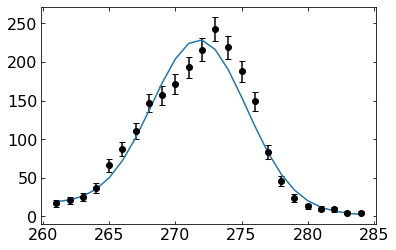

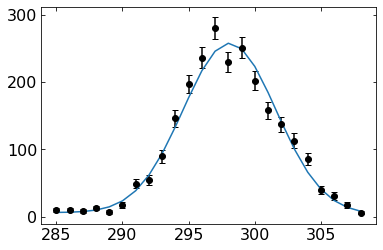

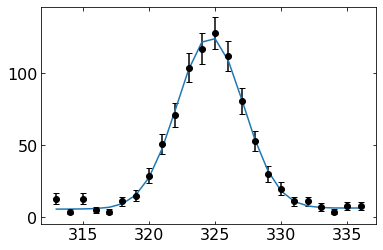

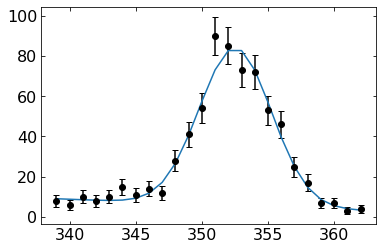

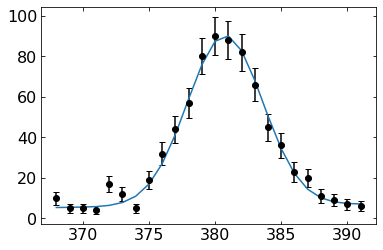

In [13]:
#Now fitting to the found peaks, in order to get an error on the channel

# defining a function to fit to
def func_fit(x, A,mu,sigma,a,b):
  x = np.array(x)
  return a*x+b +A/(sigma * np.sqrt(2*np.pi)) * np.exp(-1/2 * (x-mu)**2/(sigma**2))

#Using the make_fit function as defined way above
glimmer_data = (glimmer_45_channels, glimmer_45_counts, glimmer_45_counts_error)

fit_range = 12 #range to fit in
glimmer_45_diffraction_channels = []
glimmer_45_diffraction_channels_error = []

for i in glimmer_45_diffraction_peaks:
    
  #Defining the data in the range we want to fit around each peak 
  xs = glimmer_45_channels[i-fit_range:i+fit_range]
  ys = glimmer_45_counts[i-fit_range:i+fit_range]
  y_error = glimmer_45_counts_error[i-fit_range:i+fit_range]
    
  p_init = [glimmer_45_counts[i],glimmer_45_channels[i],1,1,1]
    
  p_opt, pcov = curve_fit(func_fit, xs, ys, sigma=y_error,absolute_sigma=True,p0=p_init)
  
  fig, ax = plt.subplots(1,1)
  ax.errorbar(xs,ys,yerr = y_error, ls="", marker="o", color = "black", capsize = 3)
  ax.plot(xs, func_fit(xs,*p_opt))

  glimmer_45_diffraction_channels.append(p_opt[1])
  glimmer_45_diffraction_channels_error.append(np.sqrt(np.diag(pcov)[1]))
    
print(glimmer_45_diffraction_channels)
print(glimmer_45_diffraction_channels_error)

In [16]:
#Now doing the channel to energy conversion based on our calibration
def channel_to_energy(channel, channel_error):
    energy = m*channel+b

    term_1 = m*channel
    term_1_error = error_prop(1,1,m,channel,m_err,channel_error,5)
    energy_error = error_prop(1,1,term_1,b,term_1_error,b_err,2)

    return [energy,energy_error]

glimmer_45_diffraction_energies = []
glimmer_45_diffraction_energies_error = []

for channel, channel_error in zip(glimmer_45_diffraction_channels, glimmer_45_diffraction_channels_error):
    out = channel_to_energy(channel,channel_error)

    glimmer_45_diffraction_energies.append(out[0])
    glimmer_45_diffraction_energies_error.append(out[1])


The crystal plane spacing for muscovite is found to be:
1.025 ± 0.002 nm


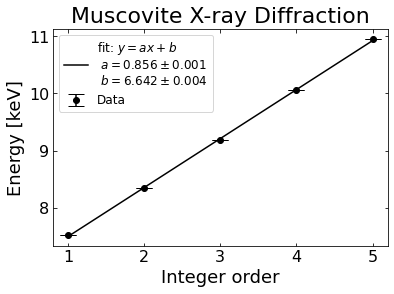

In [17]:
#Plotting the energies with respect to a given n, then fitting to find the spacing from the slope
fig,ax = plt.subplots(1,1)

ns = np.linspace(1,5,5) #list of "integers" (they are floats here but who cares) aka the "n" in the formula

#Plotting the energies as a function of n
ax.errorbar(ns,glimmer_45_diffraction_energies,yerr=glimmer_45_diffraction_energies_error,ls="",marker="o",color="black",capsize=8, label = "Data")

#Fitting to the data
xs = ns
ys = glimmer_45_diffraction_energies
y_error = glimmer_45_diffraction_energies_error

p_init = [1,1]

def func_fit(x,a,b):
    return a*x+b

p_opt, pcov = curve_fit(func_fit, xs, ys, sigma=y_error,absolute_sigma=True,p0=p_init)
p_opt_error = np.sqrt(np.diag(pcov))

#print(p_opt_error)

ax.plot(ns,func_fit(ns,*p_opt),color="black",label =f'fit: $y= ax+b$ \n $a = {p_opt[0] :.3} \pm {p_opt_error[0] :.1}$ \n $b = {p_opt[1] :.4} \pm {p_opt_error[1] :.1}$' )

ax.set_title("Muscovite X-ray Diffraction")
ax.set_ylabel("Energy [keV]")
ax.set_xlabel("Integer order")
ax.legend()

#Here calculating the actual spacing from knowing "a" and a bunch of constants
h = 4.136*10**(-18) #keV*s
c = 299792458 #m/s

glimmer_45_plane_spacing = h*c/(2*np.sin(np.pi/4)*p_opt[0])

#Doing the error propagation
part_error = 1/p_opt[0]*(p_opt_error[0]/p_opt[0])

glimmer_45_plane_spacing_error = h*c/(2*np.sin(np.pi/4)) * part_error

print("The crystal plane spacing for muscovite is found to be:")
print(np.around(glimmer_45_plane_spacing*10**9,3),"±",np.around(glimmer_45_plane_spacing_error*10**9,3) , "nm")
